# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the main functions in the Spitzer-ulens package.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner
from scipy import optimize as opt

from Spitzer_ulens import data_config
from Spitzer_ulens.MuLensEvent import MuLensEvent
from Spitzer_ulens import models
from Spitzer_ulens import PLD
from Spitzer_ulens import plot
from Spitzer_ulens import mcmc

## Defining Variables
These can be modified for use with different events and different models. See models.py for a list of the different models.

In [2]:
EVENT_NAME = 'ob171140'
TELESCOPE = 'spitzer'
EVENT_COORDS = ('17:47:31.93','-24:31:21.6')
MODELFUNC = models.single_lens
#MODELFUNC = models.binary_lens_all
MODELNAME = 'binary_lens'

## Configuration and Preparation

This section will largely draw from the data_config module.

In [3]:
load_pkl_from_file = True
load_centroid_from_file = True
save_event = True

if load_pkl_from_file and load_centroid_from_file:
    # Load event object from pre-existing pickle file
    filename = 'data/'+EVENT_NAME+'/PLD_input/'+EVENT_NAME+'_'+TELESCOPE+'.pkl'
    with open(filename, 'rb') as input:
        event = pickle.load(input)
else:
    if load_centroid_from_file:
        # Load centroid data from pre-existing centroid.out file
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.load_centroid_data(EVENT_NAME,TELESCOPE)
    else:
        # All data should be downloaded into src_dir directory
        src_dir = 'data'
        # Configure directory structure for use with data_config functions
        data_config.directory_config(EVENT_NAME,TELESCOPE,src_dir)
        # Retrieve raw centroid data
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.get_centroid_data(EVENT_NAME,TELESCOPE,EVENT_COORDS,timerange=(0,8000))
    # Obtain centroid pixel coordinates
    XCENT,YCENT = data_config.target_central_px(XDATA,YDATA)
    # Obtain 5-by-5 images and image errors
    IMG,IMG_E = data_config.target_image_square(EVENT_NAME,XCENT,YCENT,CBCD,CBUNC)
    # Create and save event object
    event = MuLensEvent(EVENT_NAME,TELESCOPE,AOR,TIMES,XDATA,YDATA,IMG,IMG_E)
    event.save()

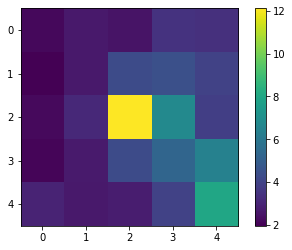

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(event.IMG[1][40])
fig.colorbar(im)
plt.show()

## Least-Squares Fit

Text(0, 0.5, 'Flux (MJy/sr)')

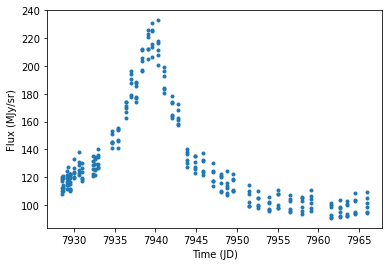

In [5]:
# Get raw photometry, error, and binned error
ptot,ptot_err,err_bin = event.aperture_photometry()
times = event.TIMES
# Plot our raw data so that we can make some parameter estimates.
plt.plot(times.ravel(),ptot.ravel(),'.')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (MJy/sr)')

In [6]:
print(err_bin)

5.443927042609956


In [7]:
# Make an initial guess for model parameters, which will be used as starting point for LM fit

# Single lens model:
fb,t0,fs,tE = 84.86,7940.195,19.707,14.58
p0 = np.array([fb,t0,fs,tE]) #for single lens: fb, t0, fs, tE
bounds = ([0,7935,0,0],[140,7945,np.inf,np.inf])

# Binary lens model:
#s     = 0.815       # separation between the two lenses (in Einstein radius of total mass)
#q     = 0.0099      # mass ratio: Right-lens' mass divided by left-lens' mass
#rho   = 1e-6        # source radius in Einstein radii of the total mass.
#alpha = np.pi-2.561 # angle between lens axis and source trajectory (rad) VBBL_alpha = PI-OSU_alpha
#tE    = 14.58       # einstein radius crossing time
#t0    = 7940.195    # time of peak magnification
#u0    = 0.1343      # impact parameter
#fb    = 76          # baseline flux
#fs    = 21          # source flux
#p0 = np.asarray([s, q, rho, alpha, tE, t0, u0, fb, fs])
# Estimate some bounds on these parameters. These do not have to be tight constraints.
#bounds = ([0,0,0,-np.inf,0,7920,-np.inf,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,7960,np.inf,np.inf,np.inf])
# Fancy parameter labels
#fancylabels = np.array([r'$s$', r'$q$', r'$\rho$', r'$alpha$', r'$t_E$', r'$t_0$', r'$u_0$', r'$f_b$', r'$f_s$'])

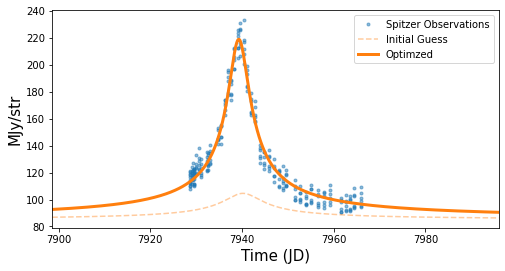

In [8]:
# Perform LM fit and plot resulting curve
popt, pcov = opt.curve_fit(f=MODELFUNC,xdata=times.ravel(),ydata=ptot.ravel(),p0=p0,bounds=bounds) 
perr = np.sqrt(np.diag(pcov)) # assuming uncorrelated
bestfit = MODELFUNC(times.ravel(),*popt)
resi_pre = ptot.ravel()-bestfit

# Plot results
timeplot = np.linspace(np.min(times.ravel())-30, np.max(times.ravel())+30, 1000)
lcguess = MODELFUNC(timeplot,*p0)
lcoptim = MODELFUNC(timeplot,*popt)
fig = plt.figure(figsize = (8,4))
plt.plot(times.ravel(), ptot.ravel(), '.', label='Spitzer Observations', alpha=0.5)
plt.plot(timeplot, lcguess, '--', label='Initial Guess', alpha=0.4)
plt.plot(timeplot, lcoptim, label='Optimzed', color='C1', linewidth=3)
plt.xlabel('Time (JD)', fontsize=15)
plt.ylabel('MJy/str', fontsize=15)
plt.xlim(np.min(timeplot), np.max(timeplot))
plt.legend()

## Solving PLD Coefficients Analytically

RMS before  :  6.895853753023638
RMS after  :  1.6537521483440882


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

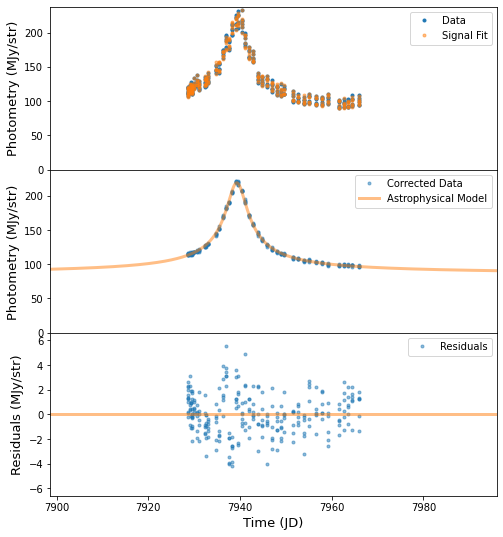

In [10]:
# Get fractional flux
pnorm = event.get_PNORM()
# Solve for PLD coefficients analytically (X)
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(times, ptot, ptot_err, pnorm, popt, MODELFUNC)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(A, Ps, X, ptot, Astro)
# Compute RMS error before and after
RMS_before, RMS_after = PLD.get_RMS(resi_pre,label='RMS before',visual=True), PLD.get_RMS(resi.ravel(),label='RMS after',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(times.ravel(), ptot.ravel(), fit.ravel(), corr.ravel(), resi.ravel(), timeplot, lcoptim)

# MCMC Fit for PLD Parameters

In [11]:
load_chain_from_file = True

if load_chain_from_file:
    # Load chains from files
    path = os.path.join('data',EVENT_NAME,'mega_MCMC',MODELNAME)
    pos_chain = np.load(path+'/samplerchain.npy')
    lnp_chain = np.load(path+'/samplerlnpro.npy')
    pos_final = np.load(path+'/samplerposit.npy')
    pld_coeff_chain = np.load(path+'/PLD_chain.npy')
else:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # Generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt,MODELFUNC,times,ptot,ptot_err,err_bin,pnorm,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    
    # Run the MCMC
    
    #First burn-in:
    pos1,prob,state = mcmc.run_mcmc(sampler,pos0,300,label='first burn-in')
    sampler.reset()

    #Second burn-in
    #Continue from best spot from last time, and do quick burn-in to get walkers spread out
    pos2 = pos1[np.argmax(prob)]
    # slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    pos2, prob, state = mcmc.run_mcmc(sampler,pos2,300,label='second burn-in')
    sampler.reset()
    
    #Run production that will be saved
    
    pos_final, prob, state = mcmc.run_mcmc(sampler,pos2,1000,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    pld_chain = PLD_chain.chain
    
    #mcmc.save_results(EVENT_NAME,pos_chain,pos_final,lnp_chain,pld_chain,folder=MODELNAME)

# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(pos_chain,lnp_chain)

In [13]:
lnp_chain.shape
pos_chain.shape

(100, 3000, 9)

In [ ]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, labels=fancylabels, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12})

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-5,7),fontsize=16)

plt.savefig('figs/binarycorners.png')

In [27]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = False
if rerun_mcmc:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt_mcmc,MODELFUNC,times,ptot,ptot_err,err_bin,pnorm,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions as the previous final parameter positions
    pos0 = pos_final
    # Run production
    pos_final,prob_final,state_final = mcmc.run_mcmc(sampler,pos0,3000,label='production')
    # Save results
    pos_chain = sampler.chain
    pld_chain = PLD_chain.chain
    lnp_chain = sampler.lnprobability
    mcmc.save_results(EVENT_NAME,pos_chain,pos_final,lnp_chain,pld_chain,folder=MODELNAME)
    # Get results from chain
    popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(pos_chain,lnp_chain)

RMS after MCMC  :  4.520727904625983


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

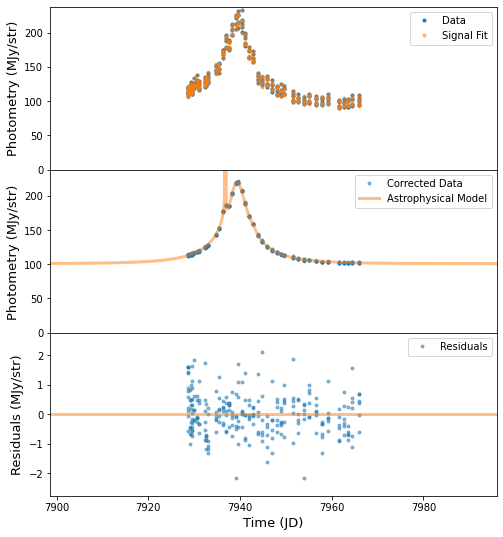

In [34]:
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(times,ptot,ptot_err,pnorm, pmax, MODELFUNC)
# Get detector model and divide it out to get new best-fit
fit_mcmc,sys_mcmc,corr_mcmc,resi_mcmc = PLD.get_bestfit(A, Ps, X, ptot, Astro)
# Compute RMS error before and after
RMS_mcmc = PLD.get_RMS(resi_mcmc,label='RMS after MCMC',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(times.ravel(),ptot.ravel(),fit_mcmc.ravel(),
                            corr_mcmc.ravel(),resi_mcmc.ravel(), 
                            timeplot, MODELFUNC(timeplot,*popt_mcmc))

# Analysis

In [13]:
# Compute BIC
bic = mcmc.get_BIC(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, X)
print(bic)

1229.4738351327953


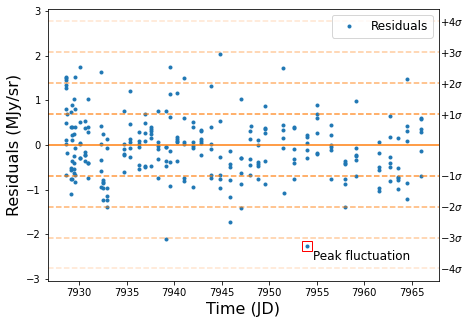

In [77]:
resi_corr = corr_mcmc-MODELFUNC(time,*popt_mcmc)
std = resi_corr.std()
indmax = np.argmax(np.abs(resi_corr))
timemax,resimax = time[indmax],resi_corr[indmax]

fig,ax = plt.subplots(figsize=(7,5))
ax.plot(time,resi_corr,'.',label='Residuals')
ax.plot(timemax,resimax,marker='s',fillstyle='none',color='red',markersize=10)
ax.text(timemax+0.7,resimax-0.3,'Peak fluctuation',fontsize=12)

ax.axhline(y=0,color='C1')
#ax.text(time[-1]+2.1,-0.1,r'best fit')
for i in range(1,5):
    ax.axhline(y=i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.axhline(y=-i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.text(time[-1]+2,i*std-0.1,r'$+%d\sigma$'%i)
    ax.text(time[-1]+2,-i*std-0.1,r'$-%d\sigma$'%i)
    
ax.set_ylabel('Residuals (MJy/sr)',fontsize=16)
ax.set_xlabel('Time (JD)',fontsize=16)

ax.legend(fontsize=12)

In [ ]:
pmin, pmax = 0, np.max(ptot)+5

# ylim for residuals
resi_std   = np.std(resi)
rmin, rmax = -4*resi_std, 4*resi_std

fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (8, 9))

axes[0].plot(time, ptot, '.', label = 'Data')
axes[0].plot(time, fit, '.', label= 'Signal Fit', color='C1', alpha=0.5)
axes[0].set_ylabel('Photometry (MJy/str)', fontsize=13)
axes[0].set_ylim(pmin, pmax)
axes[0].legend()

axes[1].plot(time, corr, '.', label='Corrected Data', alpha=0.5)
axes[1].plot(timeplot, lcoptim, label='Astrophysical Model', color='C1', linewidth=3,alpha=0.5)
axes[1].set_ylabel('Photometry (MJy/str)', fontsize=13)
axes[1].set_ylim(pmin, pmax)
axes[1].legend()

axes[2].plot(time, resi, '.', label='Residuals', alpha=0.5)
axes[2].axhline(y=0, color='C1', linewidth=3,alpha=0.5)
axes[2].set_ylabel('Residuals (MJy/str)', fontsize=13)
axes[2].set_xlabel('Time (JD)', fontsize=13)
axes[2].set_ylim(rmin, rmax)
axes[2].legend()

axes[2].set_xlim(np.min(timeplot), np.max(timeplot))

fig.subplots_adjust(hspace = 0)

# Beyond this point is outdated

In [15]:
assert False

AssertionError: 

In [ ]:
load_chain_from_file = False

if load_chain_from_file:
    # Load chains from files
    path = os.path.join('data',EVENT_NAME,'mega_MCMC')
    chain = np.load(path+'/samplerchain.npy')
    lnprob = np.load(path+'/samplerlnpro.npy')
    posit = np.load(path+'/samplerposit.npy')
    PLD_chain = np.load(path+'/PLD_chain.npy')
else:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    # Run the MCMC
    chain,posit,lnprob = mcmc.run_MCMC(sampler,pos0)
    # Retrieve PLD coefficient chain from the wrapper object
    PLD_chain = PLD_chain.chain
    # Save chains to files
    #mcmc.save_chain(EVENT_NAME,chain,posit,lnprob,PLD_chain)

In [ ]:
rerun_mcmc = True
if rerun_mcmc:
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt_mcmc,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt_mcmc*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    # Run the MCMC
    chain,posit,lnprob = mcmc.run_MCMC(sampler,pos0,)
    # Retrieve PLD coefficient chain from the wrapper object
    PLD_chain = PLD_chain.chain
    #mcmc.save_chain(EVENT_NAME,chain,posit,lnprob,PLD_chain)

In [ ]:
samples = chain.reshape((-1, len(popt_mcmc)))[500:]
fancylabels = np.array([r'$s$', r'$q$', r'$\rho$', r'$alpha$', r'$t_E$', r'$t_0$', r'$u_0$', r'$f_b$', r'$f_s$'])

# corner plot
fig = corner.corner(samples, labels=fancylabels, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12})

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-5,7),fontsize=16)

#plt.savefig('badcorners.png')

In [ ]:
lnprob_av = np.mean(lnprob)
popt_mcmc = np.mean(chain,axis=(0,1))
print(popt_mcmc.shape)

In [ ]:
# Optimal parameters are the average position of the walkers
#popt_mcmc = np.mean(posit,axis=0)
# Solve for PLD coefficients analytically
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt_mcmc, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT_MCMC, SYS_MCMC, CORR_MCMC, RESI_MCMC = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,corr_mcmc,resi_mcmc,fit_mcmc,sys_mcmc = event.chrono_flatten(CORR_MCMC,RESI_MCMC,FIT_MCMC,SYS_MCMC)
# Compute RMS error before and after
RMS_mcmc = PLD.get_RMS(resi_mcmc,label='RMS after MCMC',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit_mcmc, corr_mcmc, resi_mcmc, timeplot, MODELFUNC(timeplot,*popt_mcmc))

# Error Analysis

In [ ]:
popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(chain,lnprob)
lnlike = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
bic = popt_mcmc.size*np.log(ptot.size)-lnlike
bic_single = 2030.5618472356946
print(bic)
print(bic_single)
print(np.exp(-0.5*bic))
print(np.exp(-0.5*bic_single))

In [ ]:
posit = chain.reshape(-1,len(p0))

# Get the percentile
percs = np.percentile(posit, [16, 50, 84],axis=0)
(MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

popt_mcmc = MCMC_Results[:,0]
std_hi = MCMC_Results[:,1]
std_lo = MCMC_Results[:,2]

# Get most probable params
probs = lnprob.flatten()
p_max = posit[np.argmax(probs)]

print(popt_mcmc)
print(p_max)
print(MCMC_Results)

# Extra Plots

In [91]:
print(posit.shape)
nbins=20
i = 2

pmin = posit.min(axis=0)
pmax = posit.max(axis=0)
bins = np.linspace(pmin,pmax,nbins)
aa,bb = np.histogram(posit[:,i],bins[:,i])
cents = 0.5*(bb[1:]+bb[:-1])

fig,ax = plt.subplots(figsize=(5,5))
ax.bar(cents,aa,width=bb[1]-bb[0],color='powderblue',edgecolor='black')

ax.axvline(popt_mcmc[i],color='C1',label='Mean')
ax.axvline(popt_mcmc[i]-std_lo[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]+std_hi[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]-2*std_lo[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]+2*std_hi[i],color='C1',ls='--')
ax.text(popt_mcmc[i]+0.0001,24850,'Mean',size='large')
ax.text(popt_mcmc[i]-std_lo[i],24900,r'$-\sigma$',size='x-large')
ax.text(popt_mcmc[i]+std_hi[i],24900,r'$+\sigma$',size='x-large')
ax.text(popt_mcmc[i]-2*std_lo[i],24900,r'$-2\sigma$',size='x-large')
ax.text(popt_mcmc[i]+2*std_hi[i],24900,r'$+2\sigma$',size='x-large')
#ax.set_xticks(bb)
ax.set_xlabel(r'Angular lens separation $s$, radians',size='xx-large')
ax.set_ylabel('Number of samples',size='xx-large')
ax.set_title(r'$s = %.4f_{-%.4f}^{+%.4f}$' % (popt_mcmc[i],std_lo[i],std_hi[i]),size='x-large')
ax.set_xlim(popt_mcmc[i]-3*std_lo[i],popt_mcmc[i]+3*std_hi[i])
plt.tight_layout()
plt.savefig('errors.png',dpi=300)

NameError: name 'posit' is not defined

In [92]:
s, q, rho, alpha, tE, t0, u0, fb, fs = p0
p0_single = np.array([9.20263259e+01, 7.93931983e+03, 1.19630450e+02, 7.66795064e+00])
fb_s,t0_s,fs_s,tE_s = p0_single
timeplot = np.linspace(t0-tE,t0+tE,1000)
fig,ax = plt.subplots(1,2,figsize=(10,3))

y1 = models.single_lens(timeplot,*p0_single)
y2 = MODELFUNC(timeplot,*p0)

w1 = 1.7
h1 = 10

w2 = 1.7
h2 = 12

ylens1 = 130
ylens2 = 130

ax[0].add_patch(patches.Ellipse((t0_s,ylens1),w1,h1,color='darkgreen'))
ax[0].text(t0_s-3,ylens1-15,'Single lens',size='large')
ax[0].text(t0_s-15,ylens1+30,'Source',size='large')
source_ts = np.linspace(t0_s-14,t0_s+14,11)
for t in source_ts:
    ax[0].add_patch(patches.Ellipse((t,ylens1+20),w1,h1,color='lightgreen',fill=False))
    
ax[1].add_patch(patches.Ellipse((t0+0.5,ylens2),w2,h2,color='darkorange'))
ax[1].add_patch(patches.Ellipse((t0-2.2,ylens2),w2/3,h2/3,color='darkorange'))
ax[1].text(t0-4,ylens2-15,'Binary lens',size='large')
ax[1].text(t0-15,ylens2+40,'Source',size='large')
source_ts = np.linspace(t0-14,t0+14,11)
for t in source_ts:
    ax[1].add_patch(patches.Ellipse((t,ylens2+30),w2,h2,color='moccasin',fill=False))

ax[0].plot(timeplot,y1,color='C2',lw=2,label='Single-lens light curve')
ax[1].plot(timeplot,y2,color='C1',lw=2,label='Binary-lens light curve')
ax[0].xaxis.set_visible(False)
#ax[0].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#ax[0].legend(fontsize=14,loc=8)
#ax[1].legend(fontsize=14,loc=8)
ax[0].yaxis.set_ticks([])
ax[0].set_ylabel('Brightness',size='x-large')
ax[0].text(7954,93,'Time',size='x-large')

if False:
    ax[0].axvline(x=t0_s,ls='--',color='lightgreen')
    ax[0].text(t0_s,110,r'$t_0$',fontsize=16)
    ax[0].plot([t0_s,t0_s+tE_s],[models.single_lens(t0_s-tE_s,*p0_single),models.single_lens(t0_s+tE_s,*p0_single)],color='lightgreen',ls='--')
    ax[0].text(t0_s+1,130,r'$t_E$',fontsize=16)
ss
    ax[1].axvline(x=t0,ls='--',color='moccasin')
    ax[1].text(t0,110,r'$t_0$',fontsize=16)
    ax[1].plot([t0,t0+tE],[MODELFUNC([t0-tE],*p0),MODELFUNC([t0+tE],*p0)],color='moccasin',ls='--')
    ax[1].text(t0+1,130,r'$t_E$',fontsize=16)

#fig.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('comparemodels.png',dpi=300)

IndentationError: unexpected indent (2059514701.py, line 52)

In [ ]:
dudchain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
lnlike = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)

bic = popt_mcmc.size*np.log(ptot.size)-lnlike

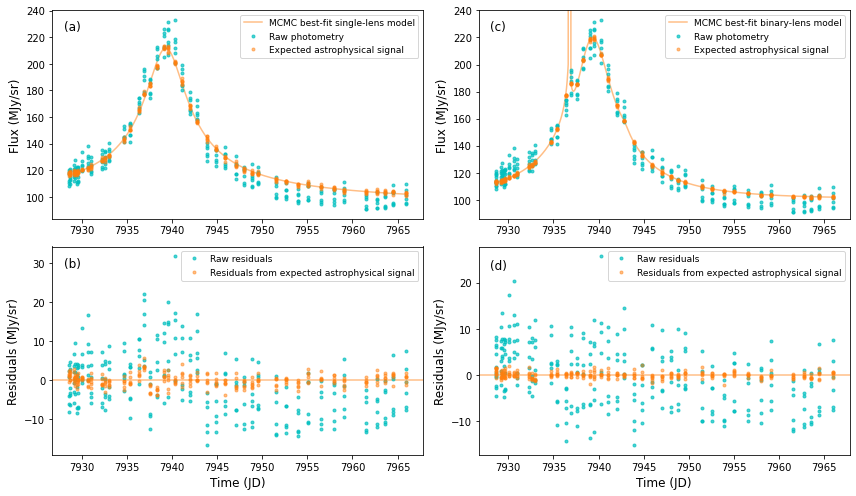

In [162]:
timeplot = np.linspace(time[0],time[-1],1000)

corr_single = np.loadtxt('single_corr.txt')
popt_single = np.loadtxt('single_pars.txt')

fig,axs = plt.subplots(2,2,figsize=(12,7))
axs[0,1].plot(timeplot,MODELFUNC(timeplot,*pmax),color='C1',alpha=0.5,label='MCMC best-fit binary-lens model')
axs[0,0].plot(timeplot,models.single_lens(timeplot,*popt_single),color='C1',alpha=0.5,label='MCMC best-fit single-lens model')
axs[0,1].plot(time,ptot,'.',color='c',alpha=0.7,label='Raw photometry')
axs[0,0].plot(time,ptot,'.',color='c',alpha=0.7,label='Raw photometry')
axs[0,1].plot(time,corr_mcmc,'.',color='C1',alpha=0.5,label='Expected astrophysical signal')
axs[0,0].plot(time,corr_single,'.',color='C1',alpha=0.5,label='Expected astrophysical signal')
axs[0,1].set_ylim(fb+10,240)

axs[1,1].axhline(color='C1',alpha=0.5)
axs[1,0].axhline(color='C1',alpha=0.5)
axs[1,1].plot(time,ptot-MODELFUNC(time,*pmax),'.',color='c',alpha=0.7,label='Raw residuals')
axs[1,0].plot(time,ptot-models.single_lens(time,*popt_single),'.',color='c',alpha=0.7,label='Raw residuals')
axs[1,1].plot(time,corr_mcmc-MODELFUNC(time,*pmax),'.',color='C1',alpha=0.5,label='Residuals from expected astrophysical signal')
axs[1,0].plot(time,corr_single-models.single_lens(time,*popt_single),'.',color='C1',alpha=0.5,label='Residuals from expected astrophysical signal')


fig.subplots_adjust(hspace=0,wspace=0.3)
#axs[0,1].yaxis.set_visible(False)
#axs[1,1].yaxis.set_visible(False)


axs[0,0].legend(fontsize=9)
axs[0,1].legend(fontsize=9)
axs[1,0].legend(fontsize=9)
axs[1,1].legend(fontsize=9)

axs[1,0].set_xlabel('Time (JD)',fontsize=12)
axs[0,0].set_ylabel('Flux (MJy/sr)',fontsize=12)
axs[1,0].set_ylabel('Residuals (MJy/sr)',fontsize=12)

axs[1,1].set_xlabel('Time (JD)',fontsize=12)
axs[0,1].set_ylabel('Flux (MJy/sr)',fontsize=12)
axs[1,1].set_ylabel('Residuals (MJy/sr)',fontsize=12)

axs[0,0].text(7928,225,'(a)',fontsize=12)
axs[0,1].text(7928,225,'(c)',fontsize=12)
axs[1,0].text(7928,29,'(b)',fontsize=12)
axs[1,1].text(7928,23,'(d)',fontsize=12)

plt.tight_layout()

plt.savefig('figs/dblsing_mcmc.png',dpi=400)

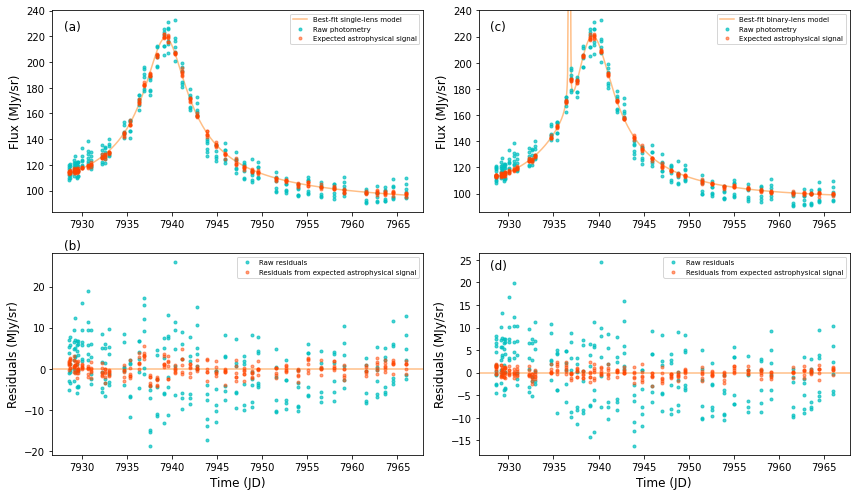

In [160]:
timeplot = np.linspace(time[0],time[-1],1000)

corr_single = np.loadtxt('s_corr_lsq.txt')
popt_single = np.loadtxt('s_popt_lsq.txt')

fig,axs = plt.subplots(2,2,figsize=(12,7))
axs[0,1].plot(timeplot,MODELFUNC(timeplot,*popt),color='C1',alpha=0.5,label='Best-fit binary-lens model')
axs[0,0].plot(timeplot,models.single_lens(timeplot,*popt_single),color='C1',alpha=0.5,label='Best-fit single-lens model')
axs[0,1].plot(time,ptot,'.',color='c',alpha=0.7,label='Raw photometry')
axs[0,0].plot(time,ptot,'.',color='c',alpha=0.7,label='Raw photometry')
axs[0,1].plot(time,corr,'.',color='orangered',alpha=0.5,label='Expected astrophysical signal')
axs[0,0].plot(time,corr_single,'.',color='orangered',alpha=0.5,label='Expected astrophysical signal')
axs[0,1].set_ylim(fb+10,240)

axs[1,1].axhline(color='C1',alpha=0.5)
axs[1,0].axhline(color='C1',alpha=0.5)
axs[1,1].plot(time,ptot-MODELFUNC(time,*popt),'.',color='c',alpha=0.7,label='Raw residuals')
axs[1,0].plot(time,ptot-models.single_lens(time,*popt_single),'.',color='c',alpha=0.7,label='Raw residuals')
axs[1,1].plot(time,corr-MODELFUNC(time,*popt),'.',color='orangered',alpha=0.5,label='Residuals from expected astrophysical signal')
axs[1,0].plot(time,corr_single-models.single_lens(time,*popt_single),'.',color='orangered',alpha=0.5,label='Residuals from expected astrophysical signal')


fig.subplots_adjust(hspace=0,wspace=0.3)
#axs[0,1].yaxis.set_visible(False)
#axs[1,1].yaxis.set_visible(False)


axs[0,0].legend(fontsize=7)
axs[0,1].legend(fontsize=7)
axs[1,0].legend(fontsize=7)
axs[1,1].legend(fontsize=7)

axs[1,0].set_xlabel('Time (JD)',fontsize=12)
axs[0,0].set_ylabel('Flux (MJy/sr)',fontsize=12)
axs[1,0].set_ylabel('Residuals (MJy/sr)',fontsize=12)

axs[1,1].set_xlabel('Time (JD)',fontsize=12)
axs[0,1].set_ylabel('Flux (MJy/sr)',fontsize=12)
axs[1,1].set_ylabel('Residuals (MJy/sr)',fontsize=12)

axs[0,0].text(7928,225,'(a)',fontsize=12)
axs[0,1].text(7928,225,'(c)',fontsize=12)
axs[1,0].text(7928,29,'(b)',fontsize=12)
axs[1,1].text(7928,23,'(d)',fontsize=12)

plt.tight_layout()

plt.savefig('figs/dblsing_lsq.png',dpi=400)

In [ ]:
timeplot = np.linspace(time[0],time[-1],1000)
bf = MODELFUNC(time,*popt_mcmc)
fig,ax = plt.subplots(figsize=(9,6))
ax.axhline(color='C1',alpha=0.7,label='Best-fit binary-lens curve')
ax.plot(time,ptot-bf,'.',color='c',alpha=0.5,label='Raw photometry')
#ax.plot(time,corr-bf,'.',color='y',alpha=0.5,label='Raw photometry corrected for LM fit')
ax.plot(time,corr_mcmc-bf,'.',color='m',alpha=0.5,label='Raw photometry corrected for MCMC fit')
ax.legend(fontsize='large')
ax.set_xlabel('Time (JD)',size='xx-large')
ax.set_ylabel('Residuals (MJy/sr)',size='xx-large')

In [ ]:
lnlike_lm = mcmc.lnlike(popt, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
bic_lm = popt.size*np.log(ptot.size)-lnlike
rms_corr = PLD.get_RMS(corr-bf)
rms_pre = PLD.get_RMS(resi_pre)
print(bic_lm)

timeplot = np.linspace(time[0],time[-1],1000)
bf = MODELFUNC(time,*popt)
fig,ax = plt.subplots(2,figsize=(8,9))

ax[0].plot(timeplot,MODELFUNC(timeplot,*p0),color='C1',alpha=0.4,label='Initital guess for binary-lens curve',ls='--')
ax[0].plot(timeplot,MODELFUNC(timeplot,*popt),color='C1',alpha=0.7,label='Least-squares best-fit binary-lens curve')
ax[0].plot(time,ptot,'.',color='c',alpha=0.5,label='Raw photometry')
ax[0].plot(time,corr,'.',color='m',alpha=0.5,label='Photometry corrected for least-squares fit')
ax[0].legend(fontsize='large')
ax[0].set_ylabel('Photometry (MJy/sr)',size='xx-large')
ax[0].xaxis.set_visible(False)

ax[0].text(7943,230,'Raw photometry RMS error: %.2f'%rms_pre,size=16)
ax[0].text(7943,210,'Corrected RMS error: %.2f'%rms_corr,size=16)

ax[1].axhline(color='C1',alpha=0.7,label='Least-squares best-fit binary-lens curve')
ax[1].plot(time,ptot-bf,'.',color='c',alpha=0.5,label='Raw photometry')
ax[1].plot(time,corr-bf,'.',color='m',alpha=0.5,label='Photometry corrected for least-squares fit')
ax[1].legend(fontsize='large')
ax[1].set_xlabel('Time (JD)',size='xx-large')
ax[1].set_ylabel('Residuals (MJy/sr)',size='xx-large')

fig.tight_layout()
plt.subplots_adjust(hspace=0)

plt.savefig('lsq_fit.png')

In [ ]:
print(popt_mcmc)

In [ ]:
_,fit = event.chrono_flatten(FIT)
print(fit.shape)
plt.plot(time,ptot-fit,'.')
#plt.plot(time,ptot,'.')

In [ ]:
dudchain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
bic = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
print(bic)

In [ ]:
np.shape(PTOT/CORR_MCMC)
print((PTOT/CORR_MCMC)[0])

In [ ]:
D = PTOT/CORR_MCMC
fig,ax = plt.subplots(figsize=(4,3))
colors=['blue','purple','green','cyan','magenta','darkorange']
for i in range(len(PTOT)):
    ax.plot(event.TIMES[i],D[i],'.',color=colors[i])
#ax.set_xlabel('Time (JD)',size='x-large')
#ax.set_ylabel('Instrumental Noise',size='x-large')
ax.axhline(y=1,color='black',lw=1,ls=(0,(5,5)))
ax.xaxis.set_ticks([])
ax.set_xlabel('Instrumental Noise',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('instrumental_noise.png')

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(timeplot,MODELFUNC(timeplot,*p0),color='dodgerblue')
#plt.xlabel('Time (JD)',size='x-large')
#plt.ylabel('Photometry',size='x-large')
ax.xaxis.set_ticks([])
ax.set_xlabel('Astrophysical Signal',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('astrophysical_model.png')

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))
for i in range(len(PTOT)):
    ax.plot(event.TIMES[i],PTOT[i],'.',color=colors[i])
#plt.xlabel('Time (JD)',size='x-large')
#plt.ylabel('Photometry',size='x-large')
ax.xaxis.set_ticks([])
ax.set_xlabel('Raw Photometry',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('raw_photometry.png')

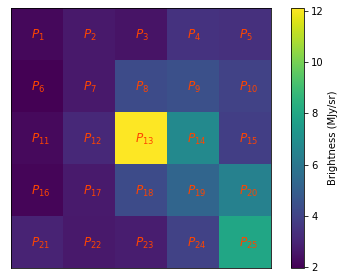

In [44]:
fig,ax = plt.subplots()
im = ax.imshow(event.IMG[1][40])
fig.colorbar(im,label='Brightness (MJy/sr)')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for i in range(5):
    for j in range(5):
        ax.text(i-0.1,j+0.1,r'$P_{%d}$'%(i+5*j+1),color='orangered',fontsize=12)
fig.tight_layout()
plt.savefig('figs/pxlabels.eps')

In [59]:
print(pmax)
print(std_hi)
print(std_lo)

[9.13864665e-01 2.71334449e-02 3.01497945e-04 7.23510315e-01
 1.26898718e+01 7.93892318e+03 1.51297364e-01 7.59886370e+01
 2.47962236e+01]
[0.00419408 0.00180796 0.0009181  0.00412293 0.24024608 0.01779103
 0.00206882 0.75916863 0.49525543]
[4.21189656e-03 1.92910844e-03 7.08692980e-04 4.42853832e-03
 2.08070896e-01 1.65973363e-02 2.18528742e-03 7.28457464e-01
 5.20349766e-01]


In [75]:
results = np.array([popt_mcmc,pmax,std_hi,std_lo]).T

In [76]:
print(results)

[[9.14623956e-01 9.14591867e-01 4.04533937e-03 4.15247416e-03]
 [2.64213114e-02 2.69259932e-02 1.77569737e-03 1.91804490e-03]
 [1.03054291e-03 2.43281513e-04 9.44955328e-04 7.18485893e-04]
 [7.23718348e-01 7.23865688e-01 4.38042739e-03 4.33572800e-03]
 [1.27773914e+01 1.27100856e+01 2.47096364e-01 2.10387958e-01]
 [7.93892859e+03 7.93892654e+03 1.71205771e-02 1.59669088e-02]
 [1.50853798e-01 1.51399045e-01 2.23975584e-03 2.30415625e-03]
 [7.60817010e+01 7.59046076e+01 7.14774631e-01 7.17132648e-01]
 [2.46143861e+01 2.47716108e+01 4.91570997e-01 5.22565113e-01]]


In [69]:
print(fancylabels)

['$s$' '$q$' '$\\rho$' '$alpha$' '$t_E$' '$t_0$' '$u_0$' '$f_b$' '$f_s$']


In [70]:
print(popt_mcmc[2])

0.0010306047575722884
